In [3]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [4]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import torch
from utils.config import Config
from learner.dataset import FragmentDataset, DataCollator
from utils.parser import command_parser
from learner.model import Loss, Frag2Mol
import argparse
import pickle
from torch.utils.data import Dataset, DataLoader

from torch.autograd import Variable
from torch.nn.utils import clip_grad_norm_
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from learner.trainer import Trainer, save_ckpt
from torch.nn import functional as F
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


# Plot Latent Space

In [49]:
config = pickle.load(open('RUNS/2022-08-08@20:20:02-LAPTOP-E1483HNR-CHEMBL/config/config.pkl', "rb"))
vocab = pickle.load(open('RUNS/2022-08-08@20:20:02-LAPTOP-E1483HNR-CHEMBL/config/vocab.pkl', "rb"))
dataset = FragmentDataset(config)
vocab = dataset.get_vocab()
model = Frag2Mol(config, vocab)
#device = torch.device('cuda')
#model = model.to(device)

Vocab created/loaded. Size: 90175. Effective size: 90175. Time elapsed: 00:00:00.


In [50]:
load_last = config.get('load_last')
trainer, epoch = Trainer.load(config, vocab, last=load_last)
model = trainer.model

loading best_loss.pt at epoch 20...


In [51]:
model

Frag2Mol(
  (embedder): Embedding(90175, 64)
  (latent2rnn): Linear(in_features=100, out_features=64, bias=True)
  (encoder): Encoder(
    (rnn): GRU(64, 64, num_layers=2, batch_first=True, dropout=0.3)
    (rnn2mean): Linear(in_features=128, out_features=100, bias=True)
    (rnn2logv): Linear(in_features=128, out_features=100, bias=True)
  )
  (decoder): Decoder(
    (rnn): GRU(64, 64, num_layers=2, batch_first=True, dropout=0.3)
    (rnn2out): Linear(in_features=64, out_features=90175, bias=True)
  )
  (mlp): MLP(
    (layers): Sequential(
      (0): Linear(in_features=100, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=32, bias=True)
      (3): ReLU()
      (4): Linear(in_features=32, out_features=1, bias=True)
    )
  )
)

In [52]:
loader = dataset.get_loader()
#mu_stack = torch.empty((32,100))
#latent_output = torch.empty((32,100))
data_sample = []
rnn2mean_weight = model.encoder.rnn2mean.weight

Data loaded. Size: 103491. Time elapsed: 00:00:00.


/home/teddy_t/miniconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py:487: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [53]:
rnn2mean_weight

Parameter containing:
tensor([[ 0.0621, -0.0392,  0.0294,  ..., -0.0526,  0.0293, -0.0486],
        [ 0.0308, -0.0068,  0.0622,  ..., -0.0364, -0.0348,  0.0736],
        [ 0.0303, -0.0484, -0.0360,  ..., -0.0290, -0.0037,  0.0666],
        ...,
        [-0.0392, -0.0008, -0.0449,  ...,  0.0891,  0.0552, -0.0401],
        [ 0.0887, -0.0270,  0.0727,  ..., -0.0788, -0.0383, -0.0655],
        [-0.0337, -0.0394,  0.0813,  ...,  0.0655, -0.0147,  0.0148]],
       device='cuda:0', requires_grad=True)

In [54]:
for idx, (src, tgt, lengths, data) in enumerate(loader):
    ###
    src, tgt = Variable(src), Variable(tgt)
    if config.get('use_gpu'):
        src = src.cuda()
        tgt = tgt.cuda()

    output, mu, sigma, z, pred = model.forward(src, lengths)
    
    print(torch.all(rnn2mean_weight == model.encoder.rnn2mean.weight))
    model.encoder.rnn2mean.weight.size() == model.encoder.rnn2mean.weight.size()
    
    ###Teddy Code
    data_sample.append(list(data))
    if idx == 0:
        mu_stack = mu
        pred_stack = pred
    else:
        mu_stack = torch.cat((mu_stack, mu), 0)
        pred_stack = torch.cat((pred_stack, pred), 0)
    print(len(mu_stack))
    if len(mu_stack) > 100000:
        break

tensor(True, device='cuda:0')
32
tensor(True, device='cuda:0')
64
tensor(True, device='cuda:0')
96
tensor(True, device='cuda:0')
128
tensor(True, device='cuda:0')
160
tensor(True, device='cuda:0')
192
tensor(True, device='cuda:0')
224
tensor(True, device='cuda:0')
256
tensor(True, device='cuda:0')
288
tensor(True, device='cuda:0')
320
tensor(True, device='cuda:0')
352
tensor(True, device='cuda:0')
384
tensor(True, device='cuda:0')
416
tensor(True, device='cuda:0')
448
tensor(True, device='cuda:0')
480
tensor(True, device='cuda:0')
512
tensor(True, device='cuda:0')
544
tensor(True, device='cuda:0')
576
tensor(True, device='cuda:0')
608
tensor(True, device='cuda:0')
640
tensor(True, device='cuda:0')
672
tensor(True, device='cuda:0')
704
tensor(True, device='cuda:0')
736
tensor(True, device='cuda:0')
768
tensor(True, device='cuda:0')
800
tensor(True, device='cuda:0')
832
tensor(True, device='cuda:0')
864
tensor(True, device='cuda:0')
896
tensor(True, device='cuda:0')
928
tensor(True, devi

7808
tensor(True, device='cuda:0')
7840
tensor(True, device='cuda:0')
7872
tensor(True, device='cuda:0')
7904
tensor(True, device='cuda:0')
7936
tensor(True, device='cuda:0')
7968
tensor(True, device='cuda:0')
8000
tensor(True, device='cuda:0')
8032
tensor(True, device='cuda:0')
8064
tensor(True, device='cuda:0')
8096
tensor(True, device='cuda:0')
8128
tensor(True, device='cuda:0')
8160
tensor(True, device='cuda:0')
8192
tensor(True, device='cuda:0')
8224
tensor(True, device='cuda:0')
8256
tensor(True, device='cuda:0')
8288
tensor(True, device='cuda:0')
8320
tensor(True, device='cuda:0')
8352
tensor(True, device='cuda:0')
8384
tensor(True, device='cuda:0')
8416
tensor(True, device='cuda:0')
8448
tensor(True, device='cuda:0')
8480
tensor(True, device='cuda:0')
8512
tensor(True, device='cuda:0')
8544
tensor(True, device='cuda:0')
8576
tensor(True, device='cuda:0')
8608
tensor(True, device='cuda:0')
8640
tensor(True, device='cuda:0')
8672
tensor(True, device='cuda:0')
8704
tensor(True, de

15456
tensor(True, device='cuda:0')
15488
tensor(True, device='cuda:0')
15520
tensor(True, device='cuda:0')
15552
tensor(True, device='cuda:0')
15584
tensor(True, device='cuda:0')
15616
tensor(True, device='cuda:0')
15648
tensor(True, device='cuda:0')
15680
tensor(True, device='cuda:0')
15712
tensor(True, device='cuda:0')
15744
tensor(True, device='cuda:0')
15776
tensor(True, device='cuda:0')
15808
tensor(True, device='cuda:0')
15840
tensor(True, device='cuda:0')
15872
tensor(True, device='cuda:0')
15904
tensor(True, device='cuda:0')
15936
tensor(True, device='cuda:0')
15968
tensor(True, device='cuda:0')
16000
tensor(True, device='cuda:0')
16032
tensor(True, device='cuda:0')
16064
tensor(True, device='cuda:0')
16096
tensor(True, device='cuda:0')
16128
tensor(True, device='cuda:0')
16160
tensor(True, device='cuda:0')
16192
tensor(True, device='cuda:0')
16224
tensor(True, device='cuda:0')
16256
tensor(True, device='cuda:0')
16288
tensor(True, device='cuda:0')
16320
tensor(True, device='c

tensor(True, device='cuda:0')
23328
tensor(True, device='cuda:0')
23360
tensor(True, device='cuda:0')
23392
tensor(True, device='cuda:0')
23424
tensor(True, device='cuda:0')
23456
tensor(True, device='cuda:0')
23488
tensor(True, device='cuda:0')
23520
tensor(True, device='cuda:0')
23552
tensor(True, device='cuda:0')
23584
tensor(True, device='cuda:0')
23616
tensor(True, device='cuda:0')
23648
tensor(True, device='cuda:0')
23680
tensor(True, device='cuda:0')
23712
tensor(True, device='cuda:0')
23744
tensor(True, device='cuda:0')
23776
tensor(True, device='cuda:0')
23808
tensor(True, device='cuda:0')
23840
tensor(True, device='cuda:0')
23872
tensor(True, device='cuda:0')
23904
tensor(True, device='cuda:0')
23936
tensor(True, device='cuda:0')
23968
tensor(True, device='cuda:0')
24000
tensor(True, device='cuda:0')
24032
tensor(True, device='cuda:0')
24064
tensor(True, device='cuda:0')
24096
tensor(True, device='cuda:0')
24128
tensor(True, device='cuda:0')
24160
tensor(True, device='cuda:0'

30720
tensor(True, device='cuda:0')
30752
tensor(True, device='cuda:0')
30784
tensor(True, device='cuda:0')
30816
tensor(True, device='cuda:0')
30848
tensor(True, device='cuda:0')
30880
tensor(True, device='cuda:0')
30912
tensor(True, device='cuda:0')
30944
tensor(True, device='cuda:0')
30976
tensor(True, device='cuda:0')
31008
tensor(True, device='cuda:0')
31040
tensor(True, device='cuda:0')
31072
tensor(True, device='cuda:0')
31104
tensor(True, device='cuda:0')
31136
tensor(True, device='cuda:0')
31168
tensor(True, device='cuda:0')
31200
tensor(True, device='cuda:0')
31232
tensor(True, device='cuda:0')
31264
tensor(True, device='cuda:0')
31296
tensor(True, device='cuda:0')
31328
tensor(True, device='cuda:0')
31360
tensor(True, device='cuda:0')
31392
tensor(True, device='cuda:0')
31424
tensor(True, device='cuda:0')
31456
tensor(True, device='cuda:0')
31488
tensor(True, device='cuda:0')
31520
tensor(True, device='cuda:0')
31552
tensor(True, device='cuda:0')
31584
tensor(True, device='c

38336
tensor(True, device='cuda:0')
38368
tensor(True, device='cuda:0')
38400
tensor(True, device='cuda:0')
38432
tensor(True, device='cuda:0')
38464
tensor(True, device='cuda:0')
38496
tensor(True, device='cuda:0')
38528
tensor(True, device='cuda:0')
38560
tensor(True, device='cuda:0')
38592
tensor(True, device='cuda:0')
38624
tensor(True, device='cuda:0')
38656
tensor(True, device='cuda:0')
38688
tensor(True, device='cuda:0')
38720
tensor(True, device='cuda:0')
38752
tensor(True, device='cuda:0')
38784
tensor(True, device='cuda:0')
38816
tensor(True, device='cuda:0')
38848
tensor(True, device='cuda:0')
38880
tensor(True, device='cuda:0')
38912
tensor(True, device='cuda:0')
38944
tensor(True, device='cuda:0')
38976
tensor(True, device='cuda:0')
39008
tensor(True, device='cuda:0')
39040
tensor(True, device='cuda:0')
39072
tensor(True, device='cuda:0')
39104
tensor(True, device='cuda:0')
39136
tensor(True, device='cuda:0')
39168
tensor(True, device='cuda:0')
39200
tensor(True, device='c

tensor(True, device='cuda:0')
46048
tensor(True, device='cuda:0')
46080
tensor(True, device='cuda:0')
46112
tensor(True, device='cuda:0')
46144
tensor(True, device='cuda:0')
46176
tensor(True, device='cuda:0')
46208
tensor(True, device='cuda:0')
46240
tensor(True, device='cuda:0')
46272
tensor(True, device='cuda:0')
46304
tensor(True, device='cuda:0')
46336
tensor(True, device='cuda:0')
46368
tensor(True, device='cuda:0')
46400
tensor(True, device='cuda:0')
46432
tensor(True, device='cuda:0')
46464
tensor(True, device='cuda:0')
46496
tensor(True, device='cuda:0')
46528
tensor(True, device='cuda:0')
46560
tensor(True, device='cuda:0')
46592
tensor(True, device='cuda:0')
46624
tensor(True, device='cuda:0')
46656
tensor(True, device='cuda:0')
46688
tensor(True, device='cuda:0')
46720
tensor(True, device='cuda:0')
46752
tensor(True, device='cuda:0')
46784
tensor(True, device='cuda:0')
46816
tensor(True, device='cuda:0')
46848
tensor(True, device='cuda:0')
46880
tensor(True, device='cuda:0'

tensor(True, device='cuda:0')
53344
tensor(True, device='cuda:0')
53376
tensor(True, device='cuda:0')
53408
tensor(True, device='cuda:0')
53440
tensor(True, device='cuda:0')
53472
tensor(True, device='cuda:0')
53504
tensor(True, device='cuda:0')
53536
tensor(True, device='cuda:0')
53568
tensor(True, device='cuda:0')
53600
tensor(True, device='cuda:0')
53632
tensor(True, device='cuda:0')
53664
tensor(True, device='cuda:0')
53696
tensor(True, device='cuda:0')
53728
tensor(True, device='cuda:0')
53760
tensor(True, device='cuda:0')
53792
tensor(True, device='cuda:0')
53824
tensor(True, device='cuda:0')
53856
tensor(True, device='cuda:0')
53888
tensor(True, device='cuda:0')
53920
tensor(True, device='cuda:0')
53952
tensor(True, device='cuda:0')
53984
tensor(True, device='cuda:0')
54016
tensor(True, device='cuda:0')
54048
tensor(True, device='cuda:0')
54080
tensor(True, device='cuda:0')
54112
tensor(True, device='cuda:0')
54144
tensor(True, device='cuda:0')
54176
tensor(True, device='cuda:0'

tensor(True, device='cuda:0')
61184
tensor(True, device='cuda:0')
61216
tensor(True, device='cuda:0')
61248
tensor(True, device='cuda:0')
61280
tensor(True, device='cuda:0')
61312
tensor(True, device='cuda:0')
61344
tensor(True, device='cuda:0')
61376
tensor(True, device='cuda:0')
61408
tensor(True, device='cuda:0')
61440
tensor(True, device='cuda:0')
61472
tensor(True, device='cuda:0')
61504
tensor(True, device='cuda:0')
61536
tensor(True, device='cuda:0')
61568
tensor(True, device='cuda:0')
61600
tensor(True, device='cuda:0')
61632
tensor(True, device='cuda:0')
61664
tensor(True, device='cuda:0')
61696
tensor(True, device='cuda:0')
61728
tensor(True, device='cuda:0')
61760
tensor(True, device='cuda:0')
61792
tensor(True, device='cuda:0')
61824
tensor(True, device='cuda:0')
61856
tensor(True, device='cuda:0')
61888
tensor(True, device='cuda:0')
61920
tensor(True, device='cuda:0')
61952
tensor(True, device='cuda:0')
61984
tensor(True, device='cuda:0')
62016
tensor(True, device='cuda:0'

tensor(True, device='cuda:0')
68480
tensor(True, device='cuda:0')
68512
tensor(True, device='cuda:0')
68544
tensor(True, device='cuda:0')
68576
tensor(True, device='cuda:0')
68608
tensor(True, device='cuda:0')
68640
tensor(True, device='cuda:0')
68672
tensor(True, device='cuda:0')
68704
tensor(True, device='cuda:0')
68736
tensor(True, device='cuda:0')
68768
tensor(True, device='cuda:0')
68800
tensor(True, device='cuda:0')
68832
tensor(True, device='cuda:0')
68864
tensor(True, device='cuda:0')
68896
tensor(True, device='cuda:0')
68928
tensor(True, device='cuda:0')
68960
tensor(True, device='cuda:0')
68992
tensor(True, device='cuda:0')
69024
tensor(True, device='cuda:0')
69056
tensor(True, device='cuda:0')
69088
tensor(True, device='cuda:0')
69120
tensor(True, device='cuda:0')
69152
tensor(True, device='cuda:0')
69184
tensor(True, device='cuda:0')
69216
tensor(True, device='cuda:0')
69248
tensor(True, device='cuda:0')
69280
tensor(True, device='cuda:0')
69312
tensor(True, device='cuda:0'

tensor(True, device='cuda:0')
75776
tensor(True, device='cuda:0')
75808
tensor(True, device='cuda:0')
75840
tensor(True, device='cuda:0')
75872
tensor(True, device='cuda:0')
75904
tensor(True, device='cuda:0')
75936
tensor(True, device='cuda:0')
75968
tensor(True, device='cuda:0')
76000
tensor(True, device='cuda:0')
76032
tensor(True, device='cuda:0')
76064
tensor(True, device='cuda:0')
76096
tensor(True, device='cuda:0')
76128
tensor(True, device='cuda:0')
76160
tensor(True, device='cuda:0')
76192
tensor(True, device='cuda:0')
76224
tensor(True, device='cuda:0')
76256
tensor(True, device='cuda:0')
76288
tensor(True, device='cuda:0')
76320
tensor(True, device='cuda:0')
76352
tensor(True, device='cuda:0')
76384
tensor(True, device='cuda:0')
76416
tensor(True, device='cuda:0')
76448
tensor(True, device='cuda:0')
76480
tensor(True, device='cuda:0')
76512
tensor(True, device='cuda:0')
76544
tensor(True, device='cuda:0')
76576
tensor(True, device='cuda:0')
76608
tensor(True, device='cuda:0'

tensor(True, device='cuda:0')
83232
tensor(True, device='cuda:0')
83264
tensor(True, device='cuda:0')
83296
tensor(True, device='cuda:0')
83328
tensor(True, device='cuda:0')
83360
tensor(True, device='cuda:0')
83392
tensor(True, device='cuda:0')
83424
tensor(True, device='cuda:0')
83456
tensor(True, device='cuda:0')
83488
tensor(True, device='cuda:0')
83520
tensor(True, device='cuda:0')
83552
tensor(True, device='cuda:0')
83584
tensor(True, device='cuda:0')
83616
tensor(True, device='cuda:0')
83648
tensor(True, device='cuda:0')
83680
tensor(True, device='cuda:0')
83712
tensor(True, device='cuda:0')
83744
tensor(True, device='cuda:0')
83776
tensor(True, device='cuda:0')
83808
tensor(True, device='cuda:0')
83840
tensor(True, device='cuda:0')
83872
tensor(True, device='cuda:0')
83904
tensor(True, device='cuda:0')
83936
tensor(True, device='cuda:0')
83968
tensor(True, device='cuda:0')
84000
tensor(True, device='cuda:0')
84032
tensor(True, device='cuda:0')
84064
tensor(True, device='cuda:0'

tensor(True, device='cuda:0')
91040
tensor(True, device='cuda:0')
91072
tensor(True, device='cuda:0')
91104
tensor(True, device='cuda:0')
91136
tensor(True, device='cuda:0')
91168
tensor(True, device='cuda:0')
91200
tensor(True, device='cuda:0')
91232
tensor(True, device='cuda:0')
91264
tensor(True, device='cuda:0')
91296
tensor(True, device='cuda:0')
91328
tensor(True, device='cuda:0')
91360
tensor(True, device='cuda:0')
91392
tensor(True, device='cuda:0')
91424
tensor(True, device='cuda:0')
91456
tensor(True, device='cuda:0')
91488
tensor(True, device='cuda:0')
91520
tensor(True, device='cuda:0')
91552
tensor(True, device='cuda:0')
91584
tensor(True, device='cuda:0')
91616
tensor(True, device='cuda:0')
91648
tensor(True, device='cuda:0')
91680
tensor(True, device='cuda:0')
91712
tensor(True, device='cuda:0')
91744
tensor(True, device='cuda:0')
91776
tensor(True, device='cuda:0')
91808
tensor(True, device='cuda:0')
91840
tensor(True, device='cuda:0')
91872
tensor(True, device='cuda:0'

tensor(True, device='cuda:0')
98688
tensor(True, device='cuda:0')
98720
tensor(True, device='cuda:0')
98752
tensor(True, device='cuda:0')
98784
tensor(True, device='cuda:0')
98816
tensor(True, device='cuda:0')
98848
tensor(True, device='cuda:0')
98880
tensor(True, device='cuda:0')
98912
tensor(True, device='cuda:0')
98944
tensor(True, device='cuda:0')
98976
tensor(True, device='cuda:0')
99008
tensor(True, device='cuda:0')
99040
tensor(True, device='cuda:0')
99072
tensor(True, device='cuda:0')
99104
tensor(True, device='cuda:0')
99136
tensor(True, device='cuda:0')
99168
tensor(True, device='cuda:0')
99200
tensor(True, device='cuda:0')
99232
tensor(True, device='cuda:0')
99264
tensor(True, device='cuda:0')
99296
tensor(True, device='cuda:0')
99328
tensor(True, device='cuda:0')
99360
tensor(True, device='cuda:0')
99392
tensor(True, device='cuda:0')
99424
tensor(True, device='cuda:0')
99456
tensor(True, device='cuda:0')
99488
tensor(True, device='cuda:0')
99520
tensor(True, device='cuda:0'

In [55]:
data_sample_index = [item for sublist in data_sample for item in sublist]

In [56]:
pred_stack.cpu().detach().numpy()

array([3.575354 , 3.5750837, 3.574903 , ..., 3.6367943, 3.6363447,
       3.6360924], dtype=float32)

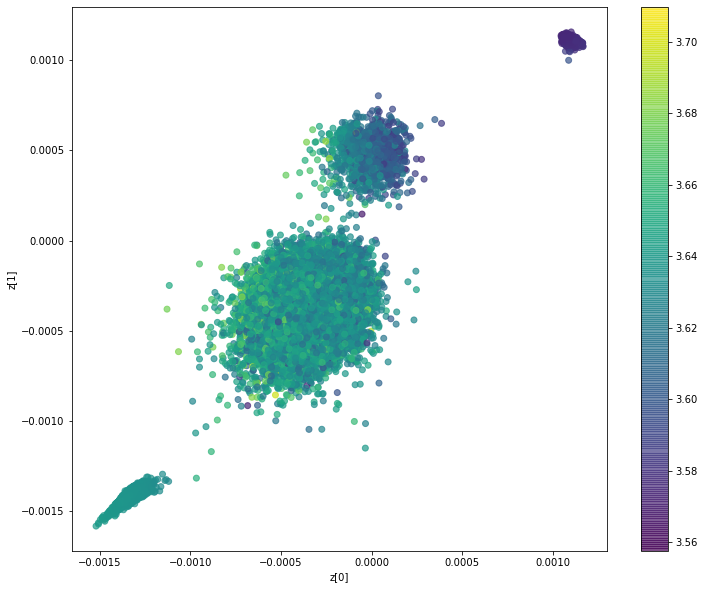

In [57]:
plt.figure(figsize=(12, 10))
plt.scatter(mu_stack[:, 1].cpu().detach().numpy(), mu_stack[:, 2].cpu().detach().numpy(), c=pred_stack.cpu().detach().numpy(), alpha=0.7)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.colorbar()
#plt.xlim(-0.0025, 0.003)
#plt.ylim(-0.0025, 0.0025)
plt.show()

In [47]:
x = mu_stack.cpu().detach().numpy()
x = StandardScaler().fit_transform(x)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])

tensor([[ 1.4013e-45,  0.0000e+00,  5.1844e+22,  ...,  3.0803e-41,
          5.1842e+22,  3.0803e-41],
        [ 5.1843e+22,  3.0803e-41,  2.8026e-45,  ...,  1.3563e-19,
          4.7431e+30,  1.7466e+19],
        [ 2.9087e+32,  1.7220e+22,  1.6020e-19,  ...,  7.1831e+22,
          1.6879e+25,  5.7010e-13],
        ...,
        [-1.0938e-03, -1.0665e-03, -9.9152e-04,  ...,  1.0645e-03,
          1.0949e-03, -9.5291e-04],
        [-1.0242e-03, -1.0672e-03, -9.7669e-04,  ...,  1.0509e-03,
          9.8428e-04, -9.2889e-04],
        [-1.2658e-03, -1.2170e-03, -1.0745e-03,  ...,  1.1769e-03,
          1.1500e-03, -1.0849e-03]], device='cuda:0', grad_fn=<CatBackward0>)

In [ ]:
principalDf

In [ ]:
plt.figure(figsize=(12, 10))
plt.scatter(principalDf['pc1'].to_numpy(), 
            principalDf['pc2'].to_numpy(), 
            c=pred_stack.cpu().detach().numpy())
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar()
#plt.xlim(-0.08, -0.075)
#plt.ylim(-0.055, -0.05)
plt.show()

# Predict property with MLP

In [48]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(100, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        
    def forward(self, x):
        x = self.layers(x)
        return x

In [49]:
data = dataset.data.iloc[data_sample_index]

In [50]:
labels = torch.tensor(data.logP.values)

In [51]:
MLP_model = MLP()

In [52]:
optimizer = torch.optim.Adam(MLP_model.parameters(), lr=0.001)
#loss_fn = F.mse_loss()
latent_output_data = mu_stack

In [54]:
latent_output_data

tensor([[ 1.4013e-45,  0.0000e+00,  5.1844e+22,  ...,  3.0803e-41,
          5.1842e+22,  3.0803e-41],
        [ 5.1843e+22,  3.0803e-41,  2.8026e-45,  ...,  1.3563e-19,
          4.7431e+30,  1.7466e+19],
        [ 2.9087e+32,  1.7220e+22,  1.6020e-19,  ...,  7.1831e+22,
          1.6879e+25,  5.7010e-13],
        ...,
        [-1.0938e-03, -1.0665e-03, -9.9152e-04,  ...,  1.0645e-03,
          1.0949e-03, -9.5291e-04],
        [-1.0242e-03, -1.0672e-03, -9.7669e-04,  ...,  1.0509e-03,
          9.8428e-04, -9.2889e-04],
        [-1.2658e-03, -1.2170e-03, -1.0745e-03,  ...,  1.1769e-03,
          1.1500e-03, -1.0849e-03]], device='cuda:0', grad_fn=<CatBackward0>)

In [55]:
mean_train_losses = []
mean_valid_losses = []
valid_acc_list = []
epochs = 20

for epoch in range(epochs):
    MLP_model.train()
    
    train_losses = []
    valid_losses = [] 
    output_final = []
    for i, (latent_data) in enumerate(latent_output_data[:9984]):
        
        outputs = MLP_model(Variable(latent_data.cpu()))
        if epoch + 1 == epochs:
            output_final.append(outputs.item())
        loss = F.mse_loss(outputs.type(torch.float64), labels[i])
        #print(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
            
    model.eval()
    mean_train_losses.append(np.mean(train_losses))
    print('epoch : {}, train loss : {:.4f}'\
         .format(epoch+1, np.mean(train_losses)))

<ipython-input-55-9b279a5281ab>:17: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(outputs.type(torch.float64), labels[i])


epoch : 1, train loss : nan
epoch : 2, train loss : nan


KeyboardInterrupt: 

In [43]:
latent_data.size()

torch.Size([100])

In [32]:
labels[i]

tensor(0.9203, dtype=torch.float64)

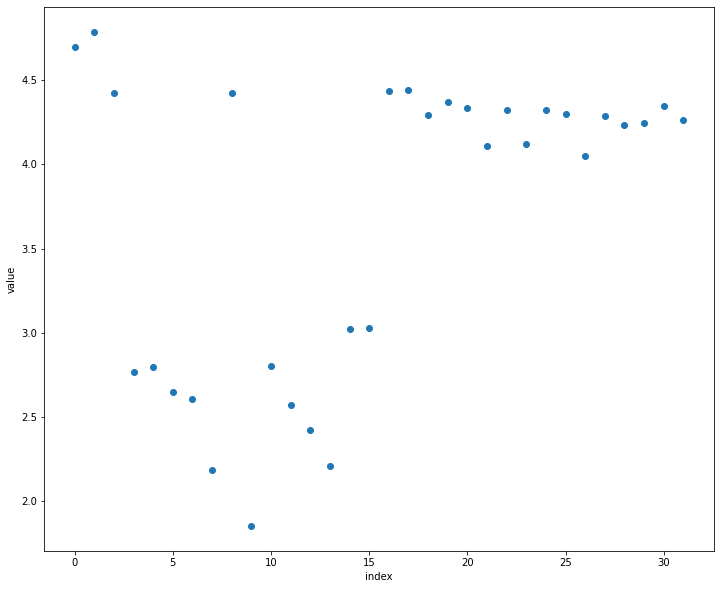

In [31]:
plt.figure(figsize=(12, 10))
plt.scatter( np.arange(len(output_final)),np.array(output_final))
#plt.scatter( np.arange(len(labels.detach().numpy())),np.array(labels.detach().numpy()))
plt.xlabel("index")
plt.ylabel("value")
#plt.xlim(100,200)
plt.show()

# Plot Net

In [62]:
outputs, mu, sigma, z, pred = model(src, lengths)

In [63]:
from torchviz import make_dot

make_dot(outputs, params=dict(list(model.named_parameters()))).render("frag_20_torchviz", format="png")

'frag_20_torchviz.png'

# Property Predictor